In [67]:
import numpy as np
import magpylib as magpy
import pandas as pd
from magpylib.magnet import Cuboid, Cylinder, CylinderSegment
from maggeometry import n_rings, halbach_cylinder
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from maghelper import get_field_on_axes, get_nonuniformity, make_flux_stream, centered_sweep_range, get_grid_mag_and_nonuniformity, make_xy_grid

In [68]:
def calc_perf(file, startindex, endindex, numrings, savefile=False, isring=True):
    f = pd.read_csv(file)
    f = f.to_numpy()
    grid_res = 101
    grid = make_xy_grid([-10, 10], [-10, 10], grid_res)
    results_g_center = []
    results_nonun = []
    if isring:
        Br = 1.09e3
        mag_dir = (0,0,1)
        mirror_z = True
        ringset_config = [Br, mag_dir, mirror_z]
        ringset_config_nomirror = [Br, mag_dir, False]
        for x in f:
            obj_ring_config = []
            if numrings == 2:
                obj_ring_config=[[*ringset_config, *x[startindex:endindex+1]]]
            if numrings == 3:
                midindex = int((endindex+1 - startindex) / 2) + startindex
                obj_ring_config=[[*ringset_config_nomirror, *x[startindex:midindex]], [*ringset_config, *x[midindex:endindex+1]]]
            if numrings == 4:
                midindex = int((endindex+1 - startindex) / 2) + startindex
                obj_ring_config=[[*ringset_config, *x[startindex:midindex]], [*ringset_config, *x[midindex:endindex+1]]]
            magnets = n_rings(obj_ring_config)
            Gmag, Gnon, center_field, av_nonuniformity, max_abs_nonuniformity = get_grid_mag_and_nonuniformity(magnets, grid, grid_res, True)
            results_g_center.append(center_field)
            results_nonun.append(av_nonuniformity)
    else:
        Br = 1.09e3
        for x in f:
            magnets = halbach_cylinder(Br, x[startindex], c_h[0], x[endindex], n)
            Gmag, Gnon, center_field, av_nonuniformity, max_abs_nonuniformity = get_grid_mag_and_nonuniformity(magnets, grid, grid_res, True)
            results_g_center.append(center_field)
            results_nonun.append(av_nonuniformity)
    return results_g_center, results_nonun


In [135]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [197]:
def pp_make_start_finish_plots(figname, guess_nonun, guess_cf, comparison_results_file, headers, n_ringsets):
    # st1 = pd.read_csv(stage1_results_file)
    # st1 = st1.to_numpy()

    cmp = pd.read_csv(comparison_results_file)
    cmp = cmp.to_numpy()
    cmp = np.delete(cmp, 0, 1)

    nplots = len(headers)
    fig_width = 25
    fig, axs = plt.subplots(1, nplots, figsize=(fig_width, 1/3*fig_width))
    # fig, axs = plt.subplots(1, 2)
    axs = axs.flat

    st2_width = cmp.shape[1]
    st2_nonun = cmp[:, 0]
    st2_field = cmp[:, 1]
    idx = 4 * n_ringsets + 2
    st1_nonun = cmp[:, idx]
    st1_field = cmp[:, idx+1]
    res = [[st1_nonun, st1_field], [st2_nonun, st2_field]]
    if (nplots == 3):
        res.insert(0, [guess_nonun, guess_cf])
    hfont = {'fontname':'Baskerville'}
    for i in range(nplots):
        axs[i].set_axisbelow(True)
        axs[i].axhline(10, color="green", linestyle="--", linewidth=0.5)
        axs[i].axhline(-10, color="green", linestyle="--", linewidth=0.5)
        axs[i].set_ylabel("Central field strength (Gauss)", **hfont)
        axs[i].set_xlabel("Nonuniformity", **hfont)
        axs[i].grid(color='.97', which='minor', axis='both', linestyle='-')
        axs[i].grid(color='.9', which='major', axis='both', linestyle='-')
        axs[i].set_title(headers[i], **hfont)
        axs[i].set_xscale("log")
        axs[i].scatter(res[i][0], res[i][1], s=14, color='blue', zorder=1)
        axs[i].yaxis.set_minor_locator(MultipleLocator(10))
    axs[0].yaxis.set_major_locator(MultipleLocator(200))
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
    plt.savefig(figname)
    # axs[1].yaxis.set_major_locator(MultipleLocator(100))
        # axs[i].set_yscale("log")
    # axs[0].set_aspect('equal')
    # axs[1].axhline(10, color="green", linestyle="--")
    # axs[1].set_ylabel("Stage 1 central field strength (Gauss)")
    # axs[1].set_xlabel("Nonuniformity")
    # axs[1].scatter(st1_nonun, st1_field)
    # axs[1].set_title("Central field strength against nonuniformity")
    # axs[1].grid(color='.9', which='major', axis='both', linestyle='-')
    # axs[1].set_xscale("log")

    # axs[2].axhline(10, color="green", linestyle="--")
    # axs[2].set_ylabel("Stage 2 central field strength (Gauss)")
    # axs[2].set_xlabel("Nonuniformity")
    # axs[2].scatter(st2_nonun, st2_field)
    # axs[2].set_title("Central field strength against nonuniformity")
    # axs[2].grid(color='.9', which='major', axis='both', linestyle='-')
    # axs[2].set_xscale("log")
    # axs[1].set_aspect('equal')
    

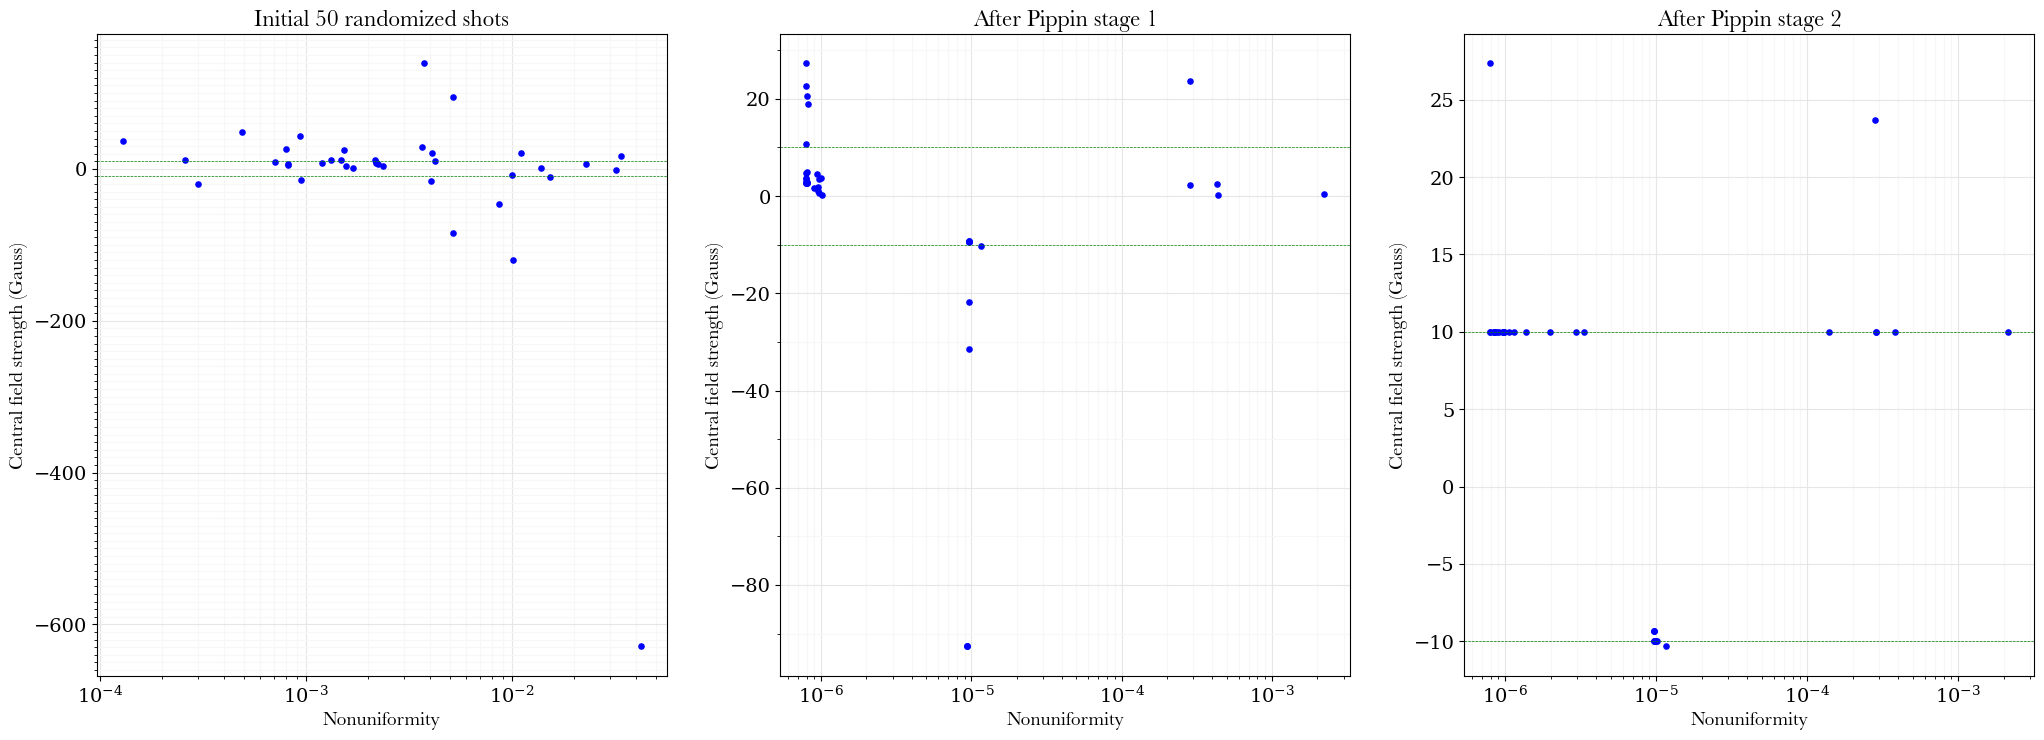

In [199]:
s1rf = 'results/2 rings/pippin/run1/with field direction/2023_08_01_pippin1_2r_1090mT_corrected_38.csv'
s2rf = 'results/2 rings/pippin/run1/with field direction/2023_08_01_pippin2_2r_1090mT_fatol1e-18_fielddir_38.csv'
crf2r = 'results/2 rings/pippin/run1/with field direction/2023_08_01_pippin2_2r_1090mT_comparison_fatol1e-18_38.csv'
# headers =[
#     "Initial central field strength against avg. nonuniformity (50 randomized shots)",
#     "Central field strength against avg. nonuniformity after Pippin stage 1",
#     "Central field strength against avg. nonuniformity after Pippin stage 2",]
headers =[
    "Initial 50 randomized shots",
    "After Pippin stage 1",
    "After Pippin stage 2",]
guess_cf2r, guess_nonun2r = calc_perf('results/2 rings/pippin/run1/with field direction/2023_08_01_pippin1_2r_1090mT_corrected_38.csv', 7, 10, 2, True)
pp_make_start_finish_plots("figs/2rresults_pp.png", guess_nonun2r, guess_cf2r, crf2r, headers, 1)

Samwise plots

In [201]:
def sw_make_start_finish_plots(figname, guess_nonun, guess_cf, final_nonun, final_cf, headers, n_ringsets):
    res = [[guess_nonun, guess_cf], [final_nonun, final_cf]]
    hfont = {'fontname':'Baskerville'}
    nplots = len(headers)
    fig_width = 25
    fig, axs = plt.subplots(1, nplots, figsize=(fig_width, 1/3*fig_width))
    axs = axs.flat
    for i in range(nplots):
        axs[i].set_axisbelow(True)
        axs[i].axhline(10, color="green", linestyle="--", linewidth=0.5)
        axs[i].axhline(-10, color="green", linestyle="--", linewidth=0.5)
        axs[i].set_ylabel("Central field strength (Gauss)", **hfont)
        axs[i].set_xlabel("Nonuniformity", **hfont)
        axs[i].grid(color='.97', which='minor', axis='both', linestyle='-')
        axs[i].grid(color='.9', which='major', axis='both', linestyle='-')
        axs[i].set_title(headers[i], **hfont)
        axs[i].set_xscale("log")
        axs[i].scatter(res[i][0], res[i][1], s=14, color='blue', zorder=1)
        axs[i].yaxis.set_minor_locator(MultipleLocator(10))
    axs[0].yaxis.set_major_locator(MultipleLocator(200))
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
    plt.savefig(figname)

[5.378568861612134, 14.65834027424183, 8.207010546383309, 13.108933251011106, 2.171004069698119, 4.906183557338433, 11.996012618498373, 5.587786890640225, 37.73722640988115, 9.641407103495894, 15.068085594296186, 2.5417558149898234, 6.765144590348933, 11.954764669680742, 2.8618699674661174, 2.8380545071102503, 4.219518584807034, 11.640060534121677, 3.5525845146712953, 200.62802248708022, -63.41956916552846, 3.0606136278362484, -7.223501787888331, 2.9276518616918867, 19.588063511919565, 19.07507301019656, 34.190776798165636, 1.2541524490912292, 6.084306202978977, 4.9785805879158564, 6.7993228344339265, 62.57032006652022, 1.615288645008377, 7.895525870192692, 0.10679801673958877, 1.8299917325455552, 12.401850277323517, -773.7382597142545, -3.497713039811927, 14.651464014674467, 2.453508377209446, -1484.4111970248593, 2.626746717069808, -72.13574589643031, 8.999085846167837, 0.17397871515047603, 87.66200242763766, -393.2597838206095, 27.02002912643295, -22.770204404548835]
[10.09731252742

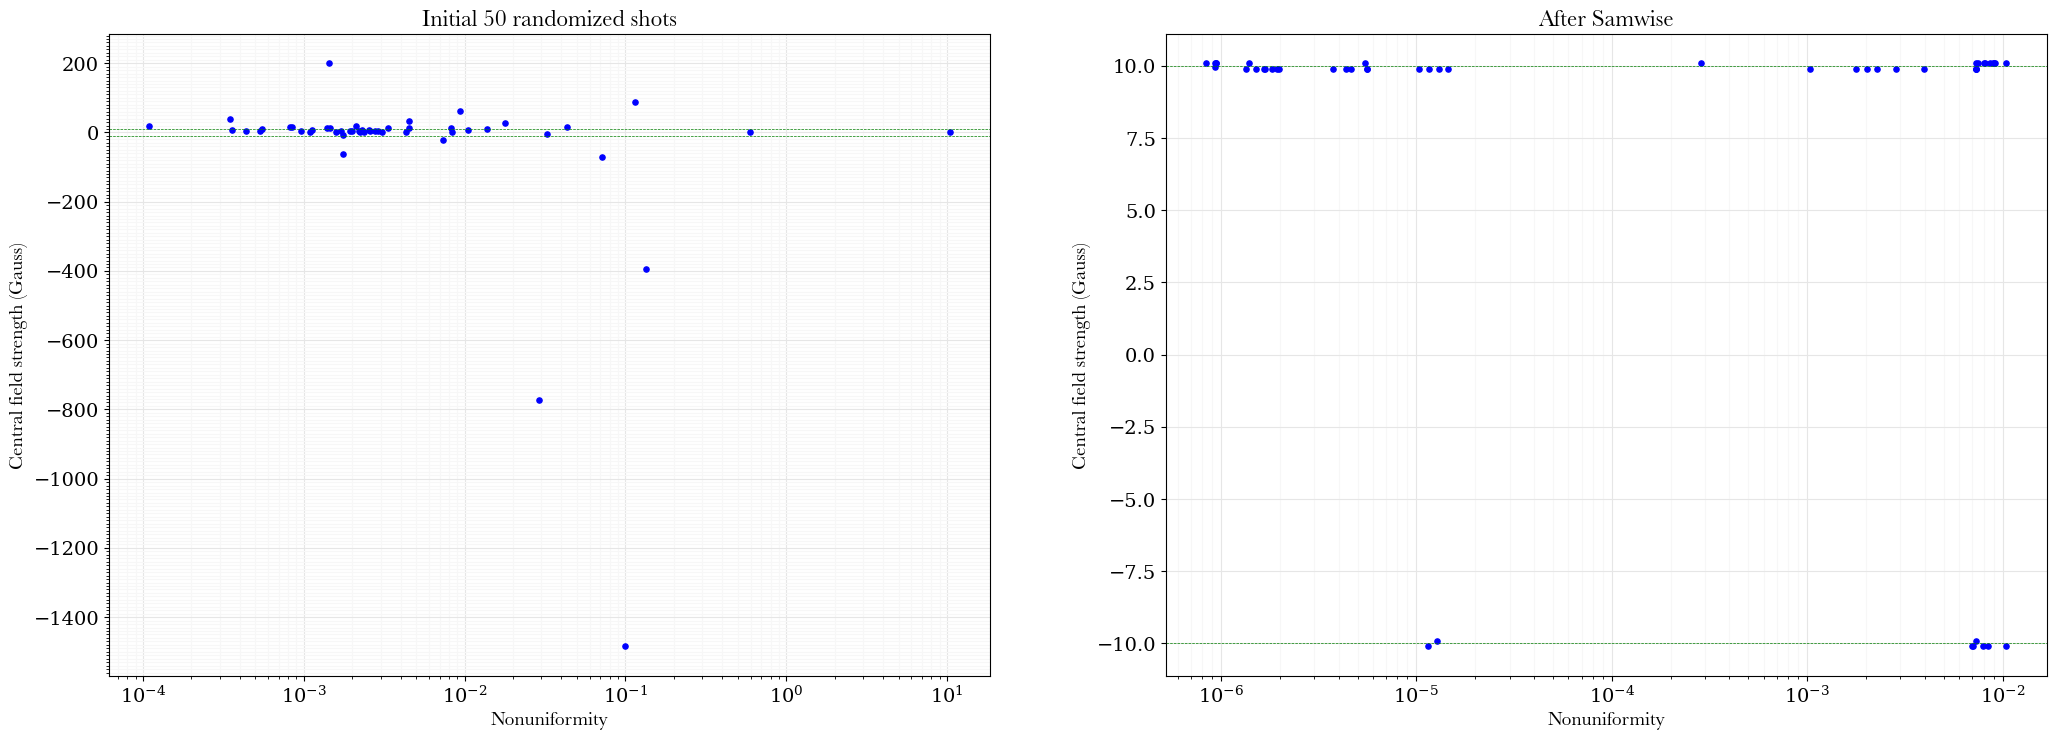

In [203]:
swheaders =[
    "Initial 50 randomized shots",
    "After Samwise",]
swres_cf2r, swres_nonun2r = calc_perf('results/2 rings/samwise/2023_07_29_samwise_sym_2r_1090mT_50.csv', 3, 6, 2, True)
swguess_cf2r, swguess_nonun2r = calc_perf('results/2 rings/samwise/2023_07_29_samwise_sym_2r_1090mT_50.csv', 7, 10, 2, True)
print (swguess_cf2r)
print(swres_cf2r)
sw_make_start_finish_plots("figs/2rresults_sw.png", swguess_nonun2r, swguess_cf2r, swres_nonun2r, swres_cf2r, swheaders, 1)

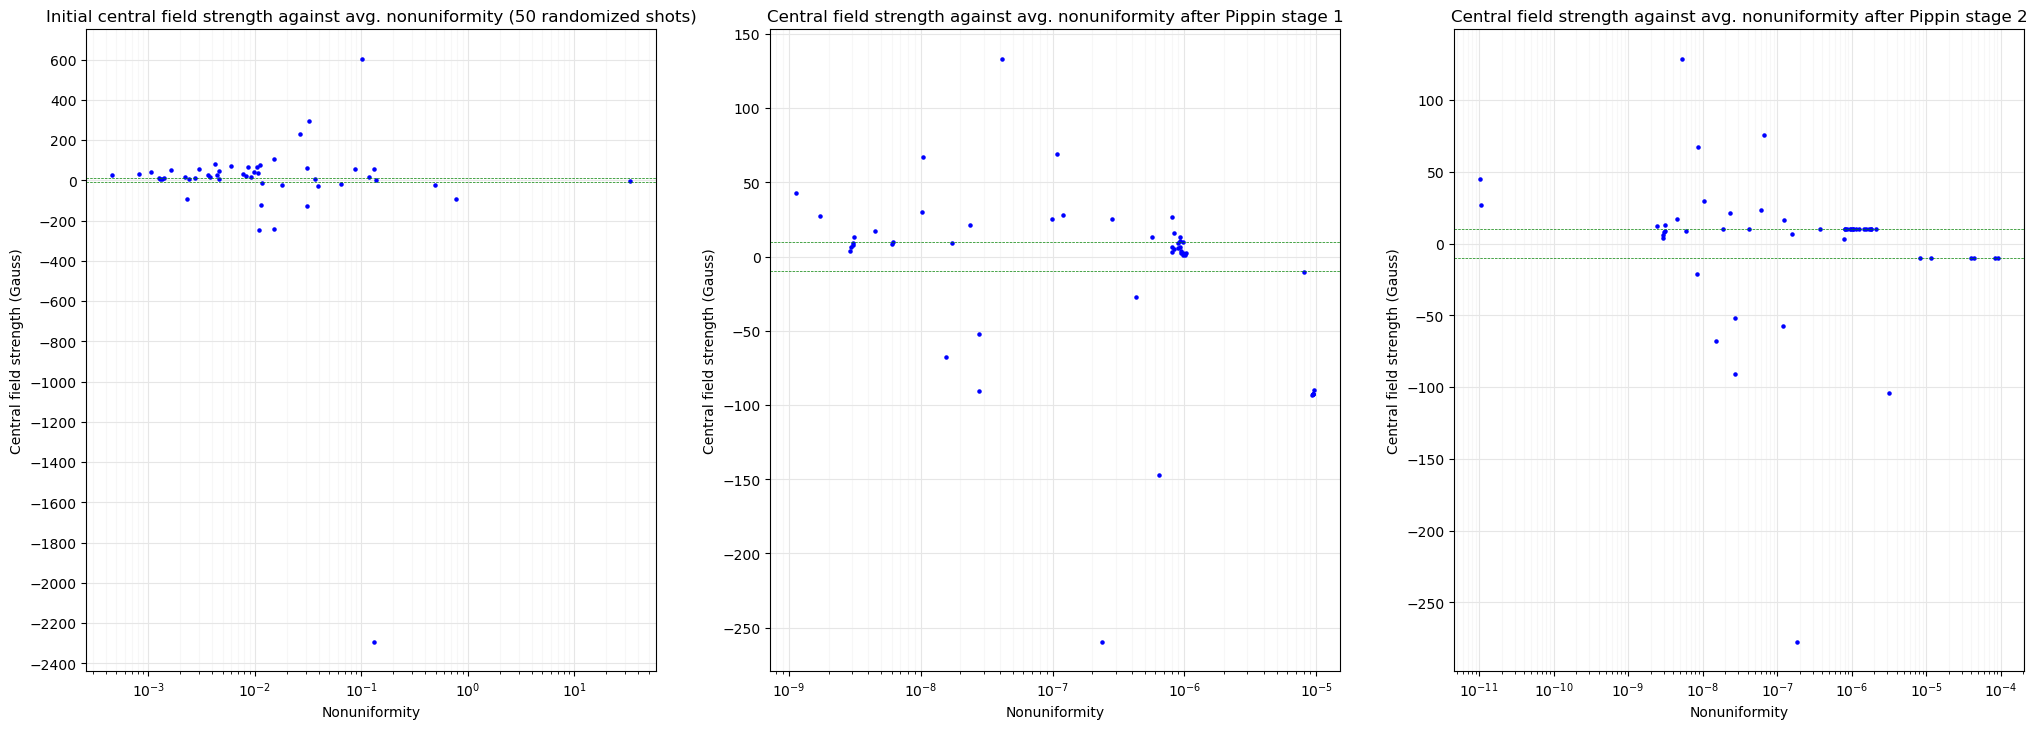

In [147]:
s1rf4r = 'results/4 rings/pippin/run1/2023_08_01_pippin1_4r_1090mT_corrected_50.csv'
s2rf4r = 'results/4 rings/pippin/run1/with field direction/2023_08_01_pippin2_2r_1090mT_fatol1e-18_fielddir_38.csv'
crf4r = 'results/4 rings/pippin/run1/2023_08_02_pippin2_4r_1090mT_comparison_50.csv'
guess_cf4r, guess_nonun4r = calc_perf('results/4 rings/pippin/run1/2023_08_01_pippin1_4r_1090mT_corrected_50.csv', 11, 19, 4, True)
pp_make_start_finish_plots(guess_nonun4r, guess_cf4r, crf4r, headers, 2)